In [1]:
pip install nltk

Note: you may need to restart the kernel to use updated packages.


In [3]:
!pip install pandas openpyxl 

In [5]:

import pandas as pd

df = pd.read_excel(r"C:\Users\jainh\Downloads\data.xlsx")

print(df.head())

                                                text  thumbsUp
0                                               ♥️♥️         0
1  BGMI is becoming more like free fire, we loved...         0
2                                          nice good         0
3                              this game is not good         0
4                                 fps drops,glitches         0


In [3]:
!pip install nltk

In [21]:
df_cleaned.to_excel(output_filename, index=False, engine='openpyxl')

In [22]:
!pip install textblob

   ---------------------------------------- 0.0/624.3 kB ? eta -:--:--
   --------------------------------- ------ 524.3/624.3 kB 3.6 MB/s eta 0:00:01
   ---------------------------------------- 624.3/624.3 kB 1.6 MB/s eta 0:00:00


In [24]:
import pandas as pd
from textblob import TextBlob
import ast # Used to safely evaluate the string representation of the list

# --- 1. Load the Preprocessed Excel File ---
input_filename = "output_file_with_steps.xlsx"
try:
    df = pd.read_excel(input_filename)
    print(f"Successfully loaded '{input_filename}'.")
except FileNotFoundError:
    print(f"Error: The file '{input_filename}' was not found. Please ensure it is in the same directory as your script.")
    exit()

# --- 2. Prepare the Text for Analysis ---
# The 'text_no_stopwords' column is stored as a string representation of a list (e.g., "['word1', 'word2']").
# We need to convert it back to an actual list of strings and then join them.

def join_tokens(token_list_str):
    try:
        # Safely evaluate the string to convert it back to a list
        tokens = ast.literal_eval(token_list_str)
        # Join the list of words into a single sentence string
        return " ".join(tokens)
    except (ValueError, SyntaxError):
        # Handle cases where the cell might be empty or malformed
        return ""

# Create a new column with the cleaned text as a single string
df['cleaned_text_joined'] = df['text_no_stopwords'].apply(join_tokens)
print("Created 'cleaned_text_joined' column for analysis.")

# --- 3. Perform Sentiment Analysis ---
# We define a function to get the polarity score from TextBlob.
def get_sentiment_score(text):
    # Create a TextBlob object
    blob = TextBlob(text)
    # Return the polarity score
    return blob.sentiment.polarity

# Apply the function to create the 'sentiment_score' column
df['sentiment_score'] = df['cleaned_text_joined'].apply(get_sentiment_score)
print("Created 'sentiment_score' column.")

# --- 4. Categorize the Sentiment ---
# We define a function to categorize the score.
def get_sentiment_category(score):
    if score > 0.1:  # Threshold for positive
        return 'Positive'
    elif score < -0.1: # Threshold for negative
        return 'Negative'
    else:
        return 'Neutral'

# Apply the function to create the 'sentiment_category' column
df['sentiment_category'] = df['sentiment_score'].apply(get_sentiment_category)
print("Created 'sentiment_category' column.")

# --- 5. Save the Final Results ---
# We can drop the intermediate 'cleaned_text_joined' column as it's no longer needed.
df_final = df.drop(columns=['cleaned_text_joined'])

output_filename = "sentiment_analysis_results.xlsx"
df_final.to_excel(output_filename, index=False, engine='openpyxl')

print(f"\nSentiment analysis complete! The results have been saved to '{output_filename}'.")
print("The new file contains all previous columns plus 'sentiment_score' and 'sentiment_category'.")

Successfully loaded 'output_file_with_steps.xlsx'.
Created 'cleaned_text_joined' column for analysis.
Created 'sentiment_score' column.
Created 'sentiment_category' column.

Sentiment analysis complete! The results have been saved to 'sentiment_analysis_results.xlsx'.
The new file contains all previous columns plus 'sentiment_score' and 'sentiment_category'.


In [25]:
!pip install matplotlib

Successfully loaded 'sentiment_analysis_results.xlsx'.

Sentiment Category Distribution:
sentiment_category
Positive    121
Neutral     109
Negative     62
Name: count, dtype: int64


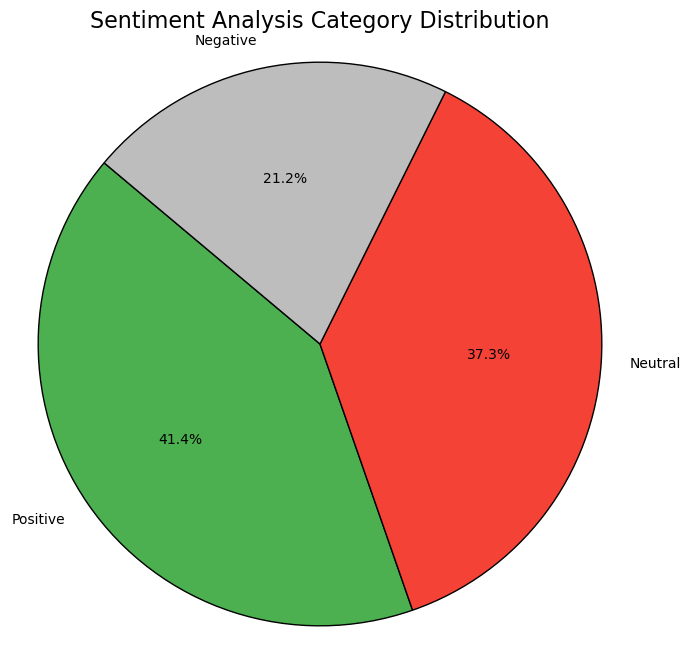

In [26]:
import pandas as pd
import matplotlib.pyplot as plt

# --- 1. Load the Sentiment Analysis Results File ---
input_filename = "sentiment_analysis_results.xlsx"
try:
    df = pd.read_excel(input_filename)
    print(f"Successfully loaded '{input_filename}'.")
except FileNotFoundError:
    print(f"Error: The file '{input_filename}' was not found. Please ensure it is in the same directory as your script.")
    exit()

# --- 2. Count the Sentiment Categories ---
# The .value_counts() method counts the number of times each unique value appears.
sentiment_counts = df['sentiment_category'].value_counts()
print("\nSentiment Category Distribution:")
print(sentiment_counts)


# --- 3. Plot the Pie Chart ---
# Define custom colors for better visual representation
colors = ['#4CAF50', '#F44336', '#BDBDBD'] # Green for Positive, Red for Negative, Grey for Neutral
# Define labels to match the order of value_counts()
labels = sentiment_counts.index

plt.figure(figsize=(8, 8))  # Set the figure size to be a nice square
plt.pie(
    sentiment_counts,
    labels=labels,
    colors=colors,
    autopct='%1.1f%%',  # Format to show percentages with one decimal place
    startangle=140,     # Rotate the chart for better aesthetics
    wedgeprops={'edgecolor': 'black'} # Add a black edge to slices
)

plt.title('Sentiment Analysis Category Distribution', fontsize=16)
plt.axis('equal')  # Ensures the pie chart is a circle.
plt.show()

In [27]:
pip install scikit-learn

In [35]:
import pandas as pd
import numpy as np
import ast
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

# --- 1. Load the Sentiment Analysis Results File ---
input_filename = "sentiment_analysis_results.xlsx"
try:
    df = pd.read_excel(input_filename)
    print(f"Successfully loaded '{input_filename}'.")
except FileNotFoundError:
    print(f"Error: The file '{input_filename}' was not found. Please ensure it is in the same directory as your script.")
    exit()

# --- 2. Prepare the Text for Modeling ---
# This is the section with the fix.
# We are now correctly using the 'text_no_stopwords' column.
def join_tokens(token_list_str):
    try:
        tokens = ast.literal_eval(str(token_list_str))
        return " ".join(tokens)
    except (ValueError, SyntaxError):
        return ""

# CORRECTED LINE: Using the actual column name 'text_no_stopwords'
cleaned_text = df['text_no_stopwords'].apply(join_tokens)
print("Prepared 'text_no_stopwords' column for topic modeling.")

# --- 3. Vectorize the Text with TF-IDF ---
vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
tfidf_matrix = vectorizer.fit_transform(cleaned_text)
print("Created TF-IDF matrix from the text data.")

# --- 4. Apply NMF Topic Modeling ---
num_topics = 5
nmf_model = NMF(n_components=num_topics, random_state=42)
W = nmf_model.fit_transform(tfidf_matrix)
H = nmf_model.components_
print(f"Applied NMF and discovered {num_topics} topics.")

# --- 5. Display the Topics and Their Top Words ---
feature_names = vectorizer.get_feature_names_out()
num_top_words = 10

print("\n--- Discovered Topics ---")
for topic_idx, topic in enumerate(H):
    top_words_indices = topic.argsort()[-num_top_words:][::-1]
    top_words = [feature_names[i] for i in top_words_indices]
    print(f"Topic #{topic_idx + 1}: {', '.join(top_words)}")

# --- 6. Assign the Dominant Topic to Each Document ---
dominant_topic = np.argmax(W, axis=1)
df['dominant_topic'] = dominant_topic + 1
print("\nAssigned a dominant topic to each row.")

# --- 7. Save the Final Results ---
output_filename = "topic_modeling_results.xlsx"
df.to_excel(output_filename, index=False, engine='openpyxl')

print(f"\nTopic modeling complete! The results have been saved to '{output_filename}'.")

Successfully loaded 'sentiment_analysis_results.xlsx'.
Prepared 'text_no_stopwords' column for topic modeling.
Created TF-IDF matrix from the text data.
Applied NMF and discovered 5 topics.

--- Discovered Topics ---
Topic #1: game, favourite, like, play, op, bad, hai, amazing, super, free
Topic #2: good, free, luck, board, glitches, bgmi, lag, excellent, work, mobile
Topic #3: nice, graphic, bgmi, cool, player, hacker, old, pls, new, year
Topic #4: best, world, bgmi, graphics, high, app, phone, wow, sabse, need
Topic #5: love, bgmi, free, se, hai, graphics, reality, play, help, player

Assigned a dominant topic to each row.

Topic modeling complete! The results have been saved to 'topic_modeling_results.xlsx'.


Successfully loaded 'sentiment_analysis_results.xlsx'.
Prepared text data for analysis.
Topic modeling complete. Now generating plots...


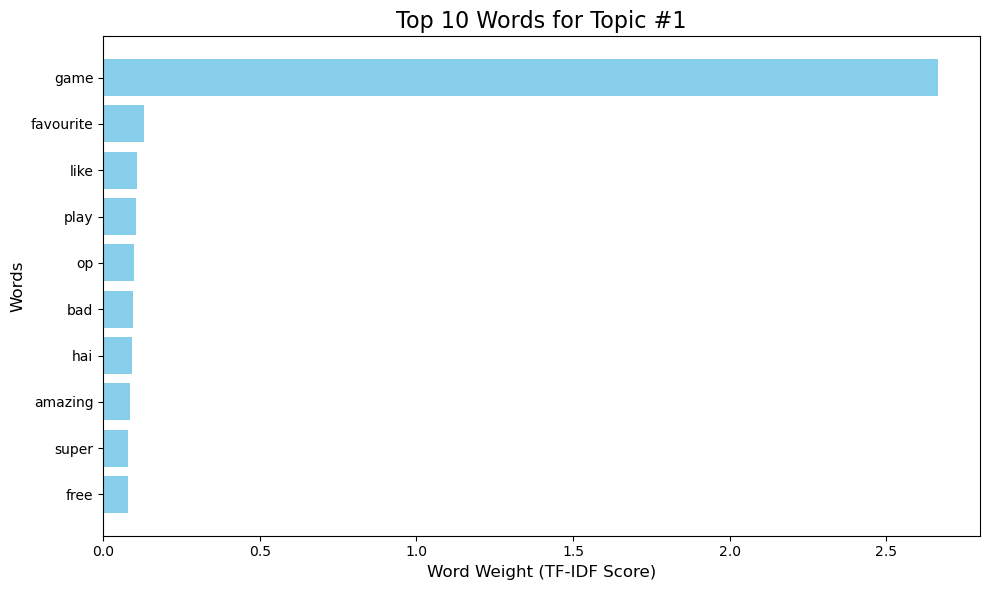

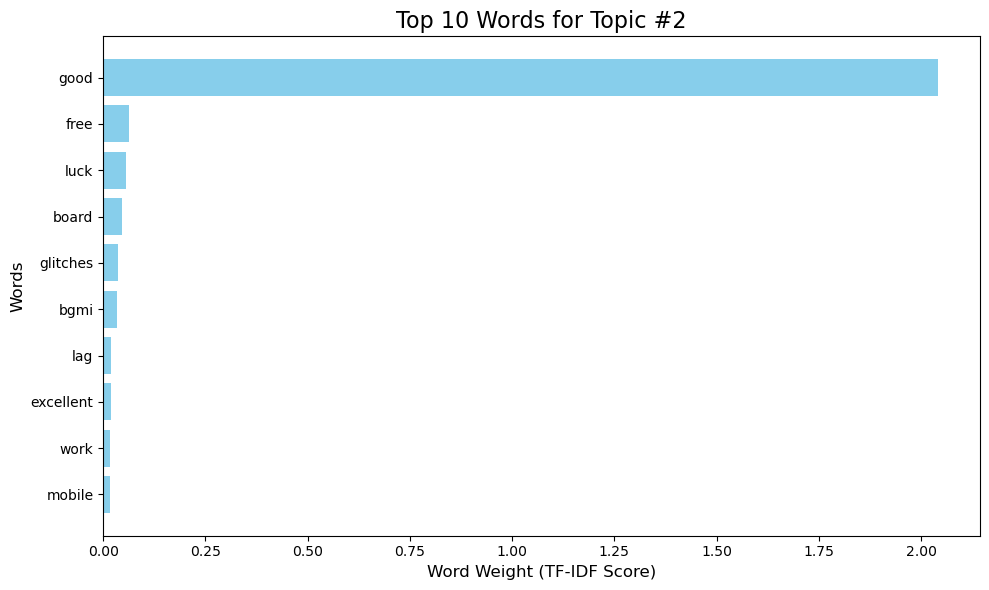

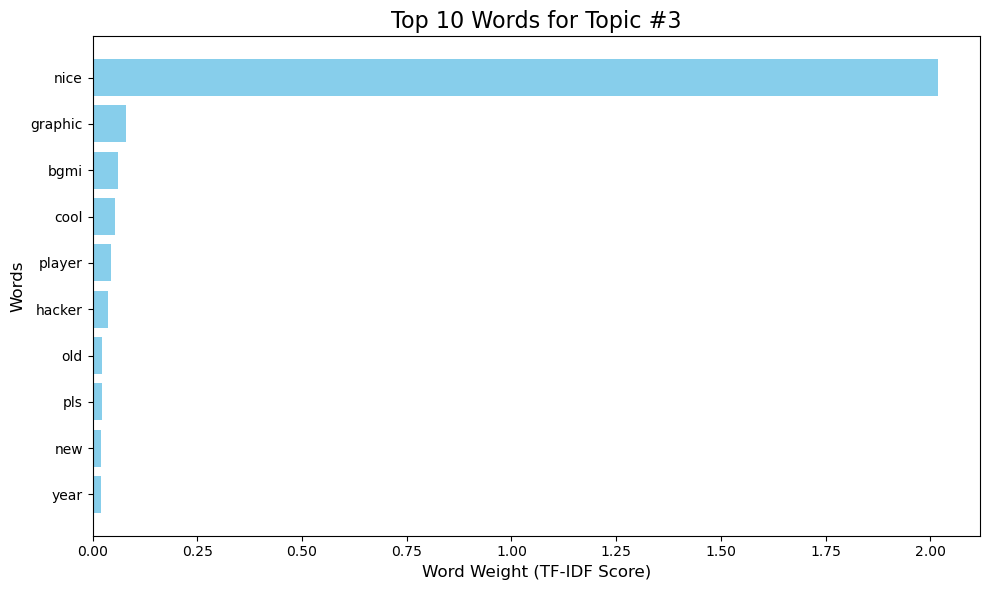

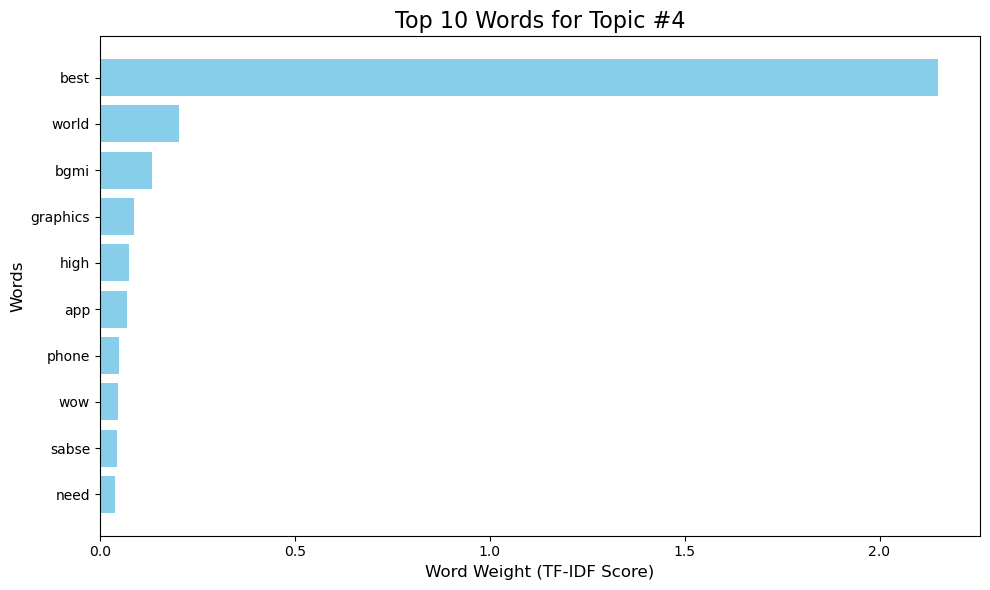

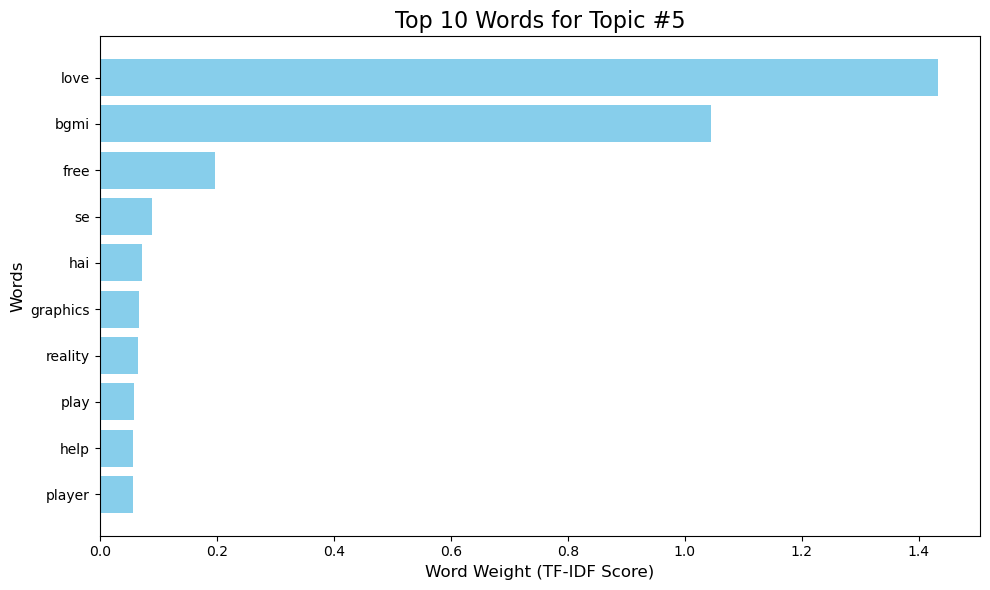

In [36]:
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

# --- 1. Load the Data and Prepare Text ---
input_filename = "sentiment_analysis_results.xlsx"
try:
    df = pd.read_excel(input_filename)
    print(f"Successfully loaded '{input_filename}'.")
except FileNotFoundError:
    print(f"Error: The file '{input_filename}' was not found. Please ensure it is in the same directory as your script.")
    exit()

# Re-create the cleaned text column for analysis
def join_tokens(token_list_str):
    try:
        tokens = ast.literal_eval(str(token_list_str))
        return " ".join(tokens)
    except (ValueError, SyntaxError):
        return ""

cleaned_text = df['text_no_stopwords'].apply(join_tokens)
print("Prepared text data for analysis.")

# --- 2. Perform NMF Topic Modeling (to get the topic-word data) ---
# We need to re-run the model to get the components for plotting.

# Vectorize the Text with TF-IDF
vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
tfidf_matrix = vectorizer.fit_transform(cleaned_text)

# Apply NMF
num_topics = 5
nmf_model = NMF(n_components=num_topics, random_state=42)
nmf_model.fit(tfidf_matrix)
H = nmf_model.components_ # The topic-word matrix

print("Topic modeling complete. Now generating plots...")

# --- 3. Generate a Bar Chart for Each Topic ---
feature_names = vectorizer.get_feature_names_out()
num_top_words = 10

for topic_idx, topic in enumerate(H):
    # Get the top N words and their weights for the current topic
    top_words_indices = topic.argsort()[-num_top_words:][::-1]
    top_words = [feature_names[i] for i in top_words_indices]
    top_word_weights = [topic[i] for i in top_words_indices]

    # Create a new figure for each plot
    plt.figure(figsize=(10, 6))
    
    # Create the horizontal bar chart
    plt.barh(top_words, top_word_weights, color='skyblue')
    
    # Invert the y-axis to have the most important word at the top
    plt.gca().invert_yaxis()
    
    # Add titles and labels for clarity
    plt.title(f'Top {num_top_words} Words for Topic #{topic_idx + 1}', fontsize=16)
    plt.xlabel('Word Weight (TF-IDF Score)', fontsize=12)
    plt.ylabel('Words', fontsize=12)
    
    # Ensure the layout is tight and clean
    plt.tight_layout()
    
    # Display the plot
    plt.show()

In [37]:
!pip install wordcloud

In [40]:
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from wordcloud import WordCloud

# --- 1. Load the Data and Prepare Text ---
input_filename = "sentiment_analysis_results.xlsx"
try:
    df = pd.read_excel(input_filename)
    print(f"Successfully loaded '{input_filename}'.")
except FileNotFoundError:
    print(f"Error: The file '{input_filename}' was not found. Please ensure it is in the same directory as your script.")
    exit()

# Re-create the cleaned text column for analysis
def join_tokens(token_list_str):
    try:
        tokens = ast.literal_eval(str(token_list_str))
        return " ".join(tokens)
    except (ValueError, SyntaxError):
        return ""

cleaned_text = df['text_no_stopwords'].apply(join_tokens)
print("Prepared text data for analysis.")

# --- 2. Perform NMF Topic Modeling (to get the topic-word data) ---
# We re-run the model to get the components needed for the word clouds.

# Vectorize the Text with TF-IDF
vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
tfidf_matrix = vectorizer.fit_transform(cleaned_text)

# Apply NMF
num_topics = 5
nmf_model = NMF(n_components=num_topics, random_state=42)
nmf_model.fit(tfidf_matrix)
H = nmf_model.components_ # The topic-word matrix

print("Topic modeling complete. Now generating word clouds...")

# --- 3. Generate a Word Cloud for Each Topic ---
feature_names = vectorizer.get_feature_names_out()

for topic_idx, topic in enumerate(H):
    # Create a dictionary of words and their weights for the current topic
    # The WordCloud object works best with a dictionary of frequencies.
    topic_words = {feature_names[i]: topic[i] for i in topic.argsort()}
    
    # Create the WordCloud object
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        colormap='viridis'  # Fixed the incomplete string 'viri' to 'viridis'
    )
    

Successfully loaded 'sentiment_analysis_results.xlsx'.
Prepared text data for analysis.
Topic modeling complete. Now generating word clouds...


Successfully loaded 'sentiment_analysis_results.xlsx'.
Prepared text data for analysis.
Topic modeling complete. Now generating word clouds...


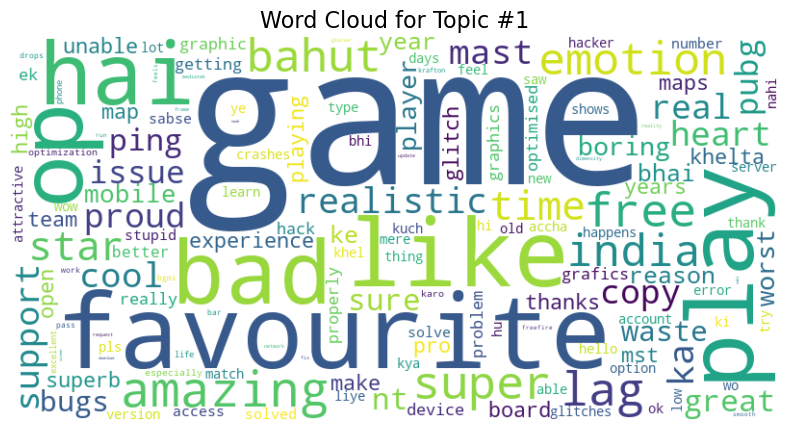

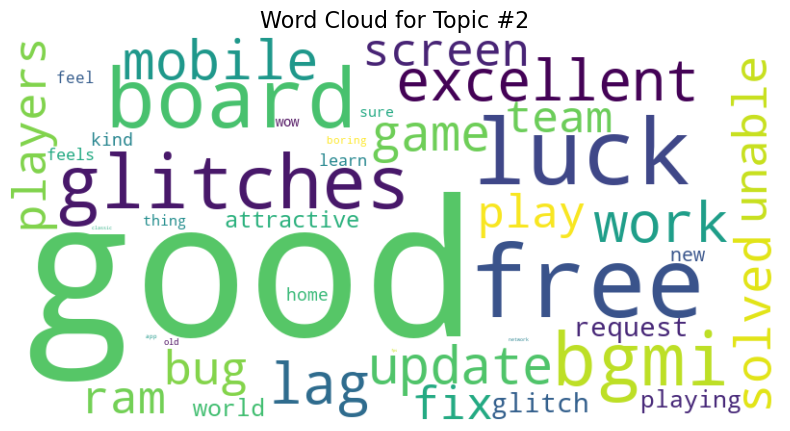

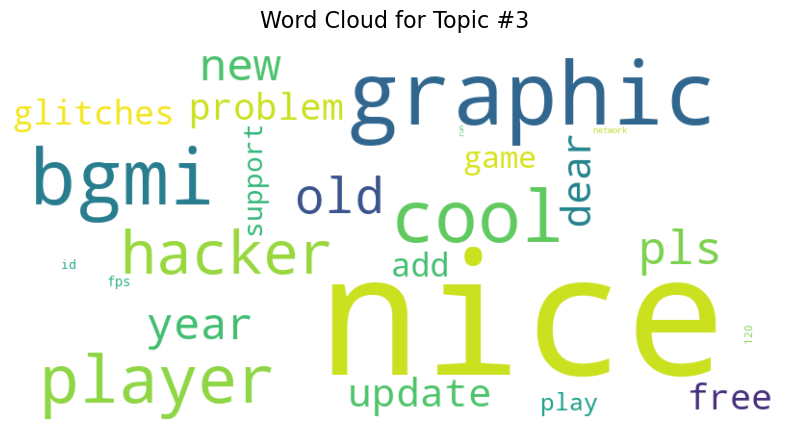

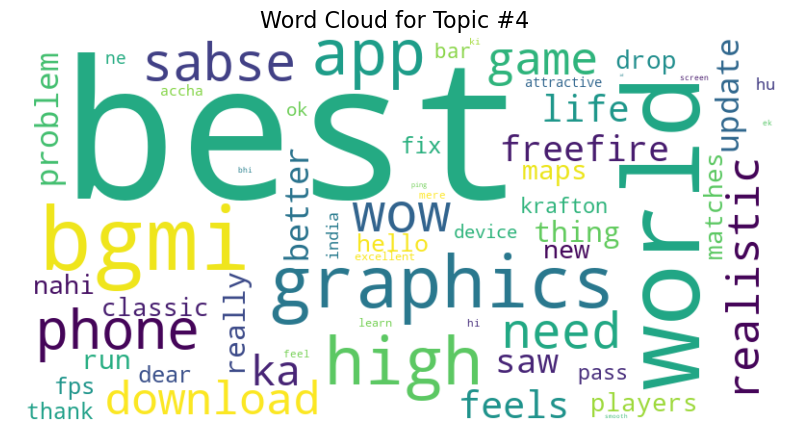

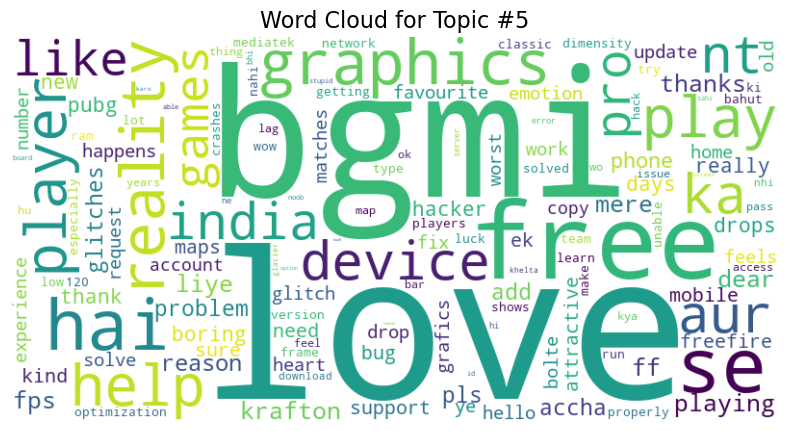

In [41]:
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from wordcloud import WordCloud

# --- 1. Load the Data and Prepare Text ---
input_filename = "sentiment_analysis_results.xlsx"
try:
    df = pd.read_excel(input_filename)
    print(f"Successfully loaded '{input_filename}'.")
except FileNotFoundError:
    print(f"Error: The file '{input_filename}' was not found. Please ensure it is in the same directory as your script.")
    exit()

# Re-create the cleaned text column for analysis
def join_tokens(token_list_str):
    try:
        tokens = ast.literal_eval(str(token_list_str))
        return " ".join(tokens)
    except (ValueError, SyntaxError):
        return ""

cleaned_text = df['text_no_stopwords'].apply(join_tokens)
print("Prepared text data for analysis.")

# --- 2. Perform NMF Topic Modeling (to get the topic-word data) ---
vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
tfidf_matrix = vectorizer.fit_transform(cleaned_text)

num_topics = 5
nmf_model = NMF(n_components=num_topics, random_state=42)
nmf_model.fit(tfidf_matrix)
H = nmf_model.components_

print("Topic modeling complete. Now generating word clouds...")

# --- 3. Generate a Word Cloud for Each Topic ---
feature_names = vectorizer.get_feature_names_out()

for topic_idx, topic in enumerate(H):
    topic_words = {feature_names[i]: topic[i] for i in topic.argsort()}
    
    # Create the WordCloud object
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        colormap='viridis'
    )
    
    # --- FIX STARTS HERE ---
    
    # STEP 1: Generate the word cloud from the topic words and their weights
    wordcloud.generate_from_frequencies(topic_words)
    
    # STEP 2: Display the generated image using matplotlib
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for Topic #{topic_idx + 1}', fontsize=16)
    plt.axis('off') # Hide the axes for a cleaner look
    plt.show()
    
    # --- FIX ENDS HERE ---